In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np
import om4labs

In [28]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [18]:
expname = "odiv-251"
path = f'/work/Katherine.Turner/CM4_storms/code/response'

archive_251 = "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp"

ds = xr.open_mfdataset(f"{archive_251}/ocean_monthly_z/ts/monthly/5yr/*obvfsq.nc", use_cftime=True)
ds_MLD = xr.open_mfdataset(f"{archive_251}/ocean_monthly/ts/monthly/5yr/*MLD_003.nc", use_cftime=True)

N2_monthly = ds.obvfsq.groupby(ds.time.dt.month).mean()
N2_monthly

N2_monthly = ds.obvfsq.groupby(ds.time.dt.month).mean()
ds_out = N2_monthly.chunk({'yh':270,'xh':720,'month':1}).to_dataset(name="obvfsq_mon")
ds_out.to_zarr("/work/Katherine.Turner/CM4_seasonality/N2_monthly")

MLD_monthly = ds_MLD.MLD_003.groupby(ds.time.dt.month).mean().to_dataset(name="MLD_003_mon").to_zarr("/work/Katherine.Turner/CM4_seasonality/MLD_monthly")

client.close()
cluster.close()

In [53]:
ds_mld = xr.open_dataset("/work/Katherine.Turner/CM4_seasonality/MLD_003_mon.1x1deg.nc")
ds_n2 = xr.open_dataset("/work/Katherine.Turner/CM4_seasonality/N2_mon.1x1deg.nc")

In [58]:
MLD

<xarray.DataArray 'MLD_003_mon' (month: 12, y: 180, x: 360)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [52.71736 , 52.75123 , 52.67668 , ..., 51.303135, 51.854958,
         52.342014],
        [51.7258  , 51.63791 , 51.6255  , ..., 52.411423, 52.118103,
         51.886738],
        [17.428383, 17.291388, 17.150501, ..., 17.816929, 17.691055,
         17.561573]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
...
        [39.52632 , 39.499287, 39.469795, ..., 39.38441 , 39.46689 ,
         39.49404 ],
        [36.78861 , 36.841248, 36.92953 , ..., 36.82877 , 36.784874,
         36.770294],
        [14.80203 , 14.687974, 14.573148, ..., 15.139705, 15.027878,
         14.915325]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [46.73604 , 46.671074, 46.56094 , ..., 46.486736, 46.62696 ,
         46.714577],
        [44.183754, 44.096375, 44.052223, ..., 44.68564 , 44.48189 ,
         44.312813],
        [15.941648, 15.831039, 15.719093, ..., 16.265516, 16.158876,
         16.050924]]], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: y, x
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area:mean yh:mean xh:mean time: mean
    long_name:      Mixed layer depth (delta rho = 0.03)
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m
    regrid_method:  bilinear

In [64]:
N2_MLD = np.zeros(shape=(12,60,360))*np.nan

MLD = ds_mld.MLD_003_mon.load()

In [65]:
for imon in np.arange(12):
    for ilat in np.arange(60):
        for ilon in np.arange(360):
            if (~np.isnan(MLD[0,ilat,ilon])):
                MLD_thresh = MLD[imon,ilat,ilon]
                N2_MLD[imon,ilat,ilon] = ds_n2.obvfsq_mon[imon,:,ilat,ilon].sel(z_i=MLD_thresh, method="nearest").data
    print(imon)

0
1
2
3
4
5
6
7
8
9
10


Task exception was never retrieved
future: <Task finished name='Task-677923' coro=<Client._gather.<locals>.wait() done, defined at /nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/distributed/client.py:2173> exception=AllExit()>
Traceback (most recent call last):
  File "/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/distributed/client.py", line 2182, in wait
    raise AllExit()
distributed.client.AllExit


11


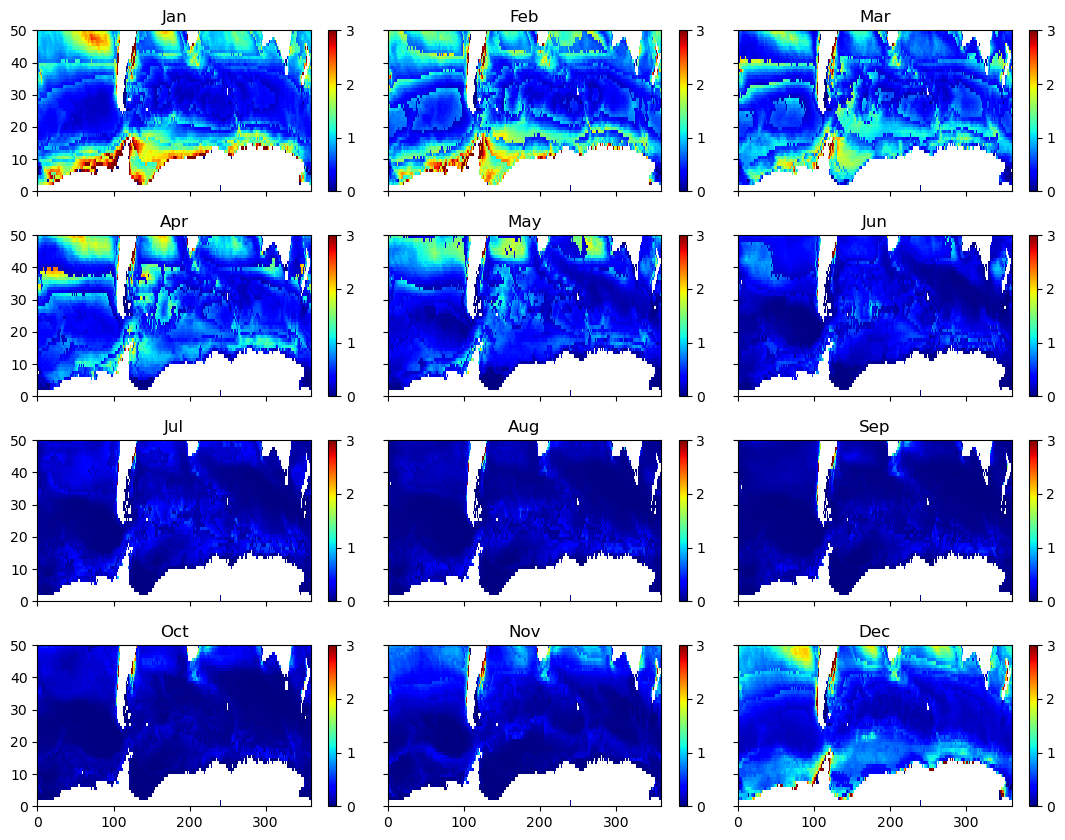

In [79]:
m = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", 'Aug', 'Sep', "Oct", "Nov", "Dec"]

fig, axs = plt.subplots(figsize=(11,8.5), nrows=4, ncols=3, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(12):

    f = axs[i].pcolormesh(1e4*N2_MLD[i,10:,:], vmin=0, vmax=3, cmap='jet')
    plt.colorbar(f, ax=axs[i])
    axs[i].set_title(m[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
plt.tight_layout()
plt.savefig("/home/Katherine.Turner/Figures/CM4_MLD_strat_clim.png", format="png", dpi=100, bbox_inches="tight")

In [80]:
client.close()
cluster.close()